In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Hiragino Sans'

ImportError: C extension: pickle not built. If you want to import pandas from the source directory, you may need to run 'python setup.py build_ext' to build the C extensions first.

In [7]:
df = pd.read_csv("flu.csv")
df["total"]

0       161
1       278
2       416
3       818
4      1385
5      1990
6      2335
7      4333
8      9926
9     12133
10    18707
11    21608
12    14947
13    10495
14     7440
15     6739
Name: total, dtype: int64

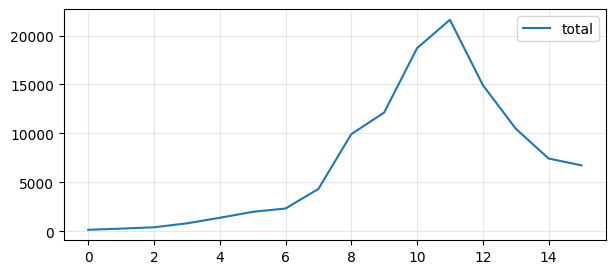

In [ ]:
df = pd.read_csv("flu.csv")
y = df["total"].to_numpy()
t = np.arange(len(y), dtype=float)

plt.figure(figsize=(7,3))
plt.plot(t, y, label="total")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [15]:
def sir_rhs(S, I, R, beta, gamma, N):
    dS = -beta*S*I/N
    dI = beta*S*I/N - gamma*I
    dR = gamma*I
    return dS, dI, dR

def euler_sir(S0, I0, R0, beta, gamma, N, t):
    S = np.empty_like(t, dtype=float)
    I = np.empty_like(t, dtype=float)
    R = np.empty_like(t, dtype=float)
    S[0], I[0], R[0] = S0, I0, R0

    h = t[1] - t[0]
    for k in range(len(t)-1):
        dS, dI, dR = sir_rhs(S[k], I[k], R[k], beta, gamma, N)
        S[k+1] = S[k] + h*dS
        I[k+1] = I[k] + h*dI
        R[k+1] = R[k] + h*dR

        # 数値誤差で負に落ちるのを避ける（教育上の安全策）
        S[k+1] = max(S[k+1], 0.0)
        I[k+1] = max(I[k+1], 0.0)
        R[k+1] = max(R[k+1], 0.0)

    return S, I, R

In [25]:
from scipy.optimize import least_squares
import numpy as np

# N = 1_000_000  # 有効人口（まず固定）
N = 600_000  # 有効人口（まず固定）

def model_incidence_euler(params):
    beta, gamma, rho, I0 = params
    S0, R0_ = N - I0, 0.0

    # データと同じ時刻グリッドで解く
    # t = t_data.copy()
    S, I, R = euler_sir(S0, I0, R0_, beta, gamma, N, t)
    inc = beta*S*I/N
    return rho*inc

def residuals(params):
    return model_incidence_euler(params) - y

x0 = np.array([0.3, 0.1, 0.2, 10.0])
lb = np.array([0.0, 0.0, 0.0, 1.0])
ub = np.array([5.0, 5.0, 10.0, 1e6])

res = least_squares(residuals, x0, bounds=(lb, ub))
beta_hat, gamma_hat, rho_hat, I0_hat = res.x

print("beta =", beta_hat)
print("gamma =", gamma_hat)
print("rho =", rho_hat)
print("I0 =", I0_hat)
print("R0 =", beta_hat/gamma_hat)

beta = 1.2439653714922394
gamma = 0.5058034589262029
rho = 0.21168322602533143
I0 = 528.3010243921912
R0 = 2.4593848648902474


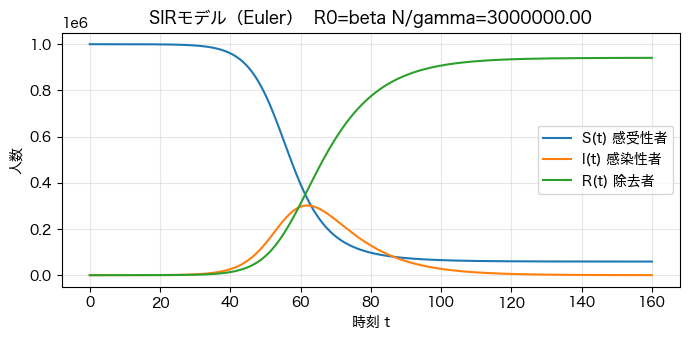

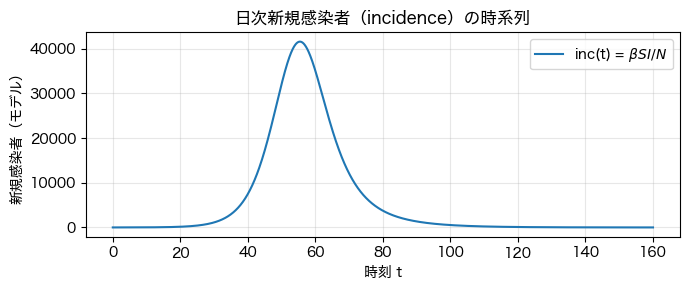

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Hiragino Sans'  # 必要なら（環境により変更）

# ===== パラメータ設定（例）=====
N = 1_000_000
beta = 0.30
gamma = 0.10

S0 = N - 10
I0 = 10
R0 = 0

# 時間軸（例：0〜160日）
t = np.linspace(0, 160, 1601)  # 刻み幅 h=0.1

# ===== 数値計算 =====
S, I, R = euler_sir(S0, I0, R0, beta, gamma, N, t)

# （任意）日次新規感染者（incidence）
inc = beta * S * I / N

# ===== 可視化：S, I, R の時系列 =====
fig, ax = plt.subplots(figsize=(7, 3.5))
ax.plot(t, S, label="S(t) 感受性者")
ax.plot(t, I, label="I(t) 感染性者")
ax.plot(t, R, label="R(t) 除去者")
ax.set_xlabel("時刻 t")
ax.set_ylabel("人数")
ax.set_title(f"SIRモデル（Euler）  R0=beta N/gamma={beta*N/gamma:.2f}")
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

# ===== 可視化：日次新規感染者（incidence） =====
fig, ax = plt.subplots(figsize=(7, 3.0))
ax.plot(t, inc, label=r"inc(t) = $\beta S I / N$")
ax.set_xlabel("時刻 t")
ax.set_ylabel("新規感染者（モデル）")
ax.set_title("日次新規感染者（incidence）の時系列")
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


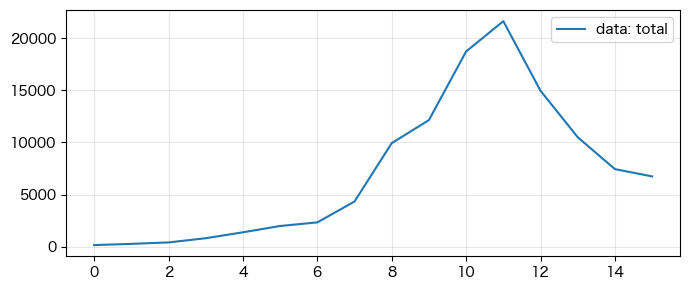

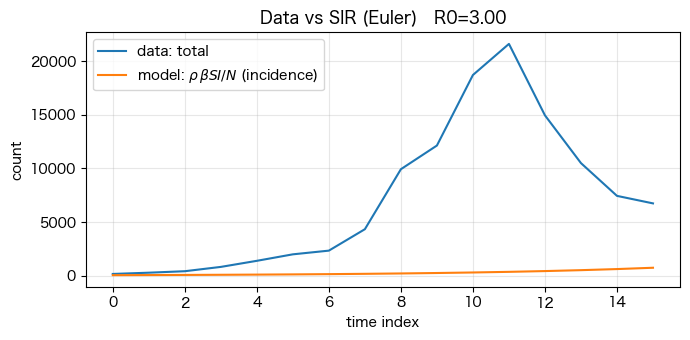

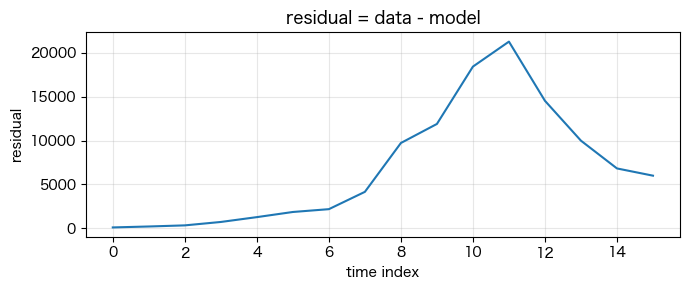

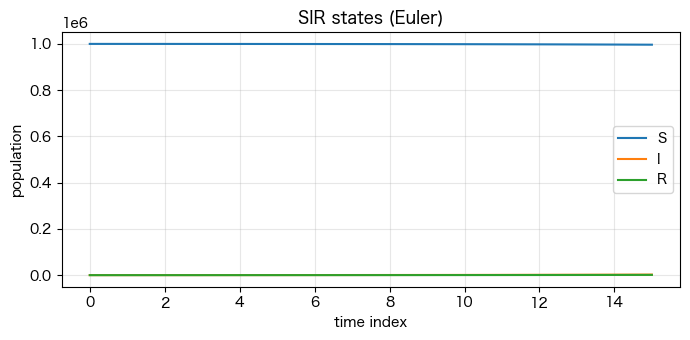

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===== データ読み込み =====
df = pd.read_csv("flu.csv")
y = df["total"].to_numpy()
t = np.arange(len(y), dtype=float)

plt.figure(figsize=(7,3))
plt.plot(t, y, label="data: total")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ===== SIR（Euler）で同じ時間軸に合わせて計算 =====
# ※ N, beta, gamma, 初期値は適宜調整してください
N = 1_000_000
beta = 0.30
gamma = 0.10

# 観測データは「感染者そのもの」ではないことが多いので、まずは
# (A) incidence（新規感染）を観測すると仮定する
# (B) スケール係数 rho を入れて比較する
rho = 1.0

I0 = max(1.0, y[0])      # まずは観測の初期値を参考に（必要なら手で調整）
R0 = 0.0
S0 = N - I0 - R0

# t は整数刻みなので、Eulerの刻み幅 h=1 として回す
S, I, R = euler_sir(S0, I0, R0, beta, gamma, N, t)

# モデル側の「観測量」を作る：incidence（単位時間あたり新規感染）
inc = beta * S * I / N
y_model = rho * inc

# ===== データ vs モデルの比較（重ね描き） =====
plt.figure(figsize=(7,3.5))
plt.plot(t, y, label="data: total")
plt.plot(t, y_model, label=r"model: $\rho\,\beta S I/N$ (incidence)")
plt.xlabel("time index")
plt.ylabel("count")
plt.title(f"Data vs SIR (Euler)   R0={beta/gamma:.2f}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ===== 残差（data - model） =====
plt.figure(figsize=(7,3))
plt.plot(t, y - y_model)
plt.xlabel("time index")
plt.ylabel("residual")
plt.title("residual = data - model")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =====（任意）S, I, Rも確認 =====
plt.figure(figsize=(7,3.5))
plt.plot(t, S, label="S")
plt.plot(t, I, label="I")
plt.plot(t, R, label="R")
plt.xlabel("time index")
plt.ylabel("population")
plt.title("SIR states (Euler)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


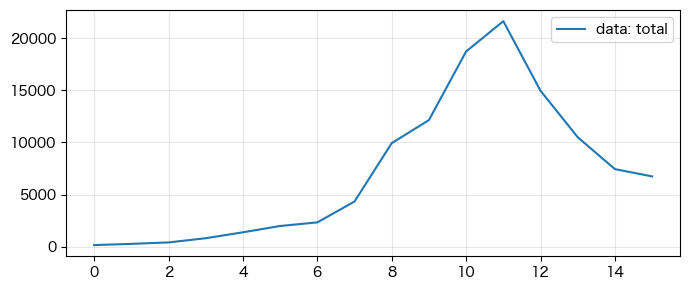

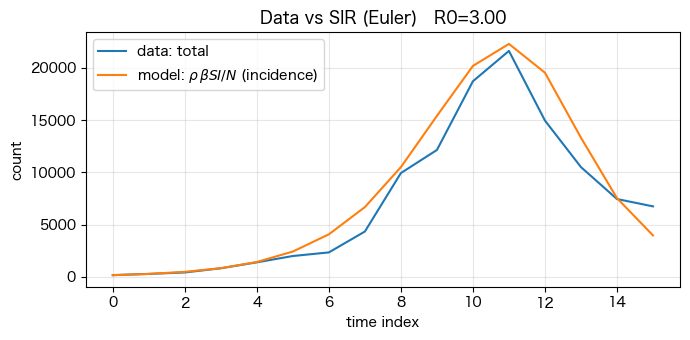

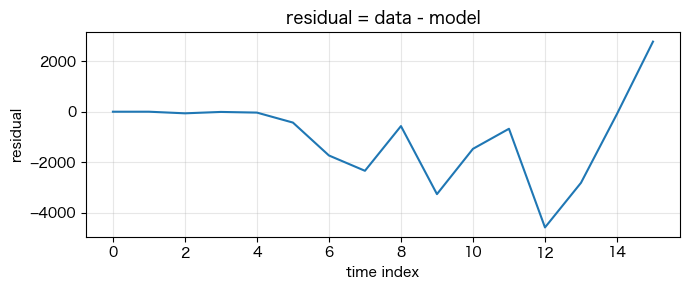

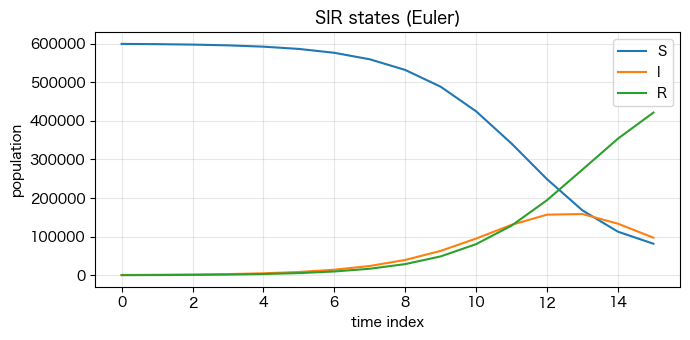

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===== データ読み込み =====
df = pd.read_csv("flu.csv")
y = df["total"].to_numpy()
t = np.arange(len(y), dtype=float)

plt.figure(figsize=(7,3))
plt.plot(t, y, label="data: total")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ===== SIR（Euler）で同じ時間軸に合わせて計算 =====
# ※ N, beta, gamma, 初期値は適宜調整してください
N = 600_000
beta = 0.30
gamma = 0.10

# 観測データは「感染者そのもの」ではないことが多いので、まずは
# (A) incidence（新規感染）を観測すると仮定する
# (B) スケール係数 rho を入れて比較する
rho = 1.0

I0 = max(1.0, y[0])      # まずは観測の初期値を参考に（必要なら手で調整）
R0 = 0.0
S0 = N - I0 - R0

# t は整数刻みなので、Eulerの刻み幅 h=1 として回す
S, I, R = euler_sir(S0, I0_hat, R0, beta_hat, gamma_hat, N, t)

# モデル側の「観測量」を作る：incidence（単位時間あたり新規感染）
inc = beta * S * I / N
y_model = rho * inc

# ===== データ vs モデルの比較（重ね描き） =====
plt.figure(figsize=(7,3.5))
plt.plot(t, y, label="data: total")
plt.plot(t, y_model, label=r"model: $\rho\,\beta S I/N$ (incidence)")
plt.xlabel("time index")
plt.ylabel("count")
plt.title(f"Data vs SIR (Euler)   R0={beta/gamma:.2f}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ===== 残差（data - model） =====
plt.figure(figsize=(7,3))
plt.plot(t, y - y_model)
plt.xlabel("time index")
plt.ylabel("residual")
plt.title("residual = data - model")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =====（任意）S, I, Rも確認 =====
plt.figure(figsize=(7,3.5))
plt.plot(t, S, label="S")
plt.plot(t, I, label="I")
plt.plot(t, R, label="R")
plt.xlabel("time index")
plt.ylabel("population")
plt.title("SIR states (Euler)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


最終規模方程式

In [2]:
def fse_residual(S, S0, N, beta, gamma, R_init=0.0):
    """FSEの左辺-右辺（=0を解く）"""
    a = beta / gamma
    return np.log(S) + a*(N - S) - (np.log(S0) + a*R_init)

def solve_fse_bisection(S0, N, beta, gamma, R_init=0.0, tol=1e-10, max_iter=200):
    """
    二分法で S_inf を解く。
    S_inf は (0, S0] にある（流行でSは減るので）。
    """
    # loからhiの間で解を探す
    # 下端は log のため0にできないので小さい正数
    lo = 1e-15 * N
    hi = S0

    f_lo = fse_residual(lo, S0, N, beta, gamma, R_init)
    f_hi = fse_residual(hi, S0, N, beta, gamma, R_init)

    # 通常パラメータでは f(lo)>0, f(hi)<=0 となり根を挟む
    # もし挟めない場合は情報を出して止める
    if f_lo * f_hi > 0:
        raise ValueError(
            "二分法の区間が根を挟んでいません。"
            f" f(lo)={f_lo:.3e}, f(hi)={f_hi:.3e}. "
            "N,beta,gamma,S0 の設定を確認してください。"
        )

    for _ in range(max_iter):
        mid = 0.5*(lo+hi)
        f_mid = fse_residual(mid, S0, N, beta, gamma, R_init)

        if abs(f_mid) < tol or (hi-lo) < tol*max(1.0, hi):
            return mid

        # 根を挟む側を更新
        if f_lo * f_mid > 0:
            lo, f_lo = mid, f_mid
        else:
            hi, f_hi = mid, f_mid

    return 0.5*(lo+hi)

In [4]:
# N = 1_000_000
# S0 = N - 10   # 初期感染がわずか
N = 1
S0 = N - 0.0001   # 初期感染がわずか

beta = 0.30
gamma = 0.10
R_init = 0.0

S_inf = solve_fse_bisection(S0, N, beta, gamma, R_init=R_init)
R_inf = N - S_inf

print(f"S_inf ≈ {S_inf:.6f}")
print(f"R_inf ≈ {R_inf:.6f}")
print(f"最終感染割合 R_inf/N ≈ {R_inf/N:.6f}")
print(f"beta/gamma = {beta/gamma:.3f}")

S_inf ≈ 0.059513
R_inf ≈ 0.940487
最終感染割合 R_inf/N ≈ 0.940487
beta/gamma = 3.000


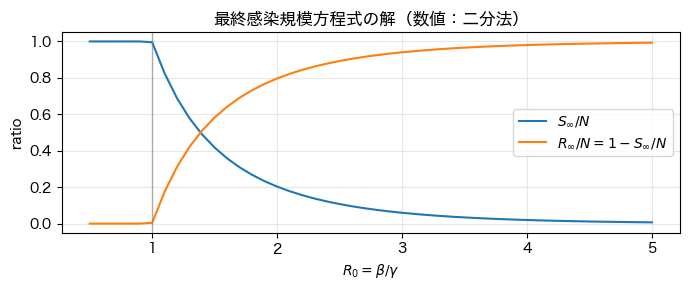

In [ ]:
N = 1.0       # 正規化して割合で見たい場合（N=1が便利）
S0 = N - 0.00001      # 初期ほぼ全員感受性（割合）
R_init = 0.0

R0_list = np.linspace(0.5, 5.0, 46)  # 0.5〜5.0
Sinf_list = []
Rinf_list = []

for R0 in R0_list:
    beta = R0  # gamma=1 とすれば beta/gamma=R0
    gamma = 1.0
    S_inf = solve_fse_bisection(S0, N, beta, gamma, R_init=R_init)
    Sinf_list.append(S_inf)
    Rinf_list.append(N - S_inf)

Sinf_list = np.array(Sinf_list)
Rinf_list = np.array(Rinf_list)

plt.figure(figsize=(7,3))
plt.plot(R0_list, Sinf_list, label=r"$S_\infty/N$")
plt.plot(R0_list, Rinf_list, label=r"$R_\infty/N = 1-S_\infty/N$")
plt.axvline(1.0, color="gray", lw=1, alpha=0.6)
plt.xlabel(r"$R_0=\beta/\gamma$")
plt.ylabel("ratio")
plt.title("基本再生産数に対する最終感染規模方程式の解")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

取得データ

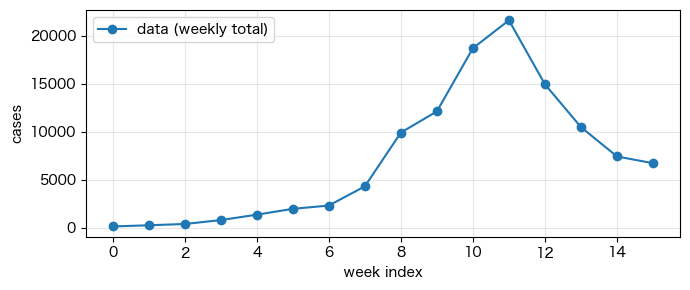

In [9]:
# 取得したデータ
y = np.array([
    161, 278, 416, 818, 1385, 1990, 2335, 4333,
    9926, 12133, 18707, 21608, 14947, 10495, 7440, 6739
], dtype=float)
t = np.arange(len(y), dtype=float)  # 週インデックス（0,1,2,...）

plt.figure(figsize=(7,3))
plt.plot(t, y, "o-", label="data (weekly total)")
plt.xlabel("week index")
plt.ylabel("cases")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
def sir_rhs_frac(s, i, r, beta, gamma):
    ds = -beta*s*i
    di = beta*s*i - gamma*i
    dr = gamma*i
    return ds, di, dr

def euler_sir_frac(s0, i0, r0, beta, gamma, t):
    s = np.empty_like(t, dtype=float)
    i = np.empty_like(t, dtype=float)
    r = np.empty_like(t, dtype=float)
    s[0], i[0], r[0] = s0, i0, r0
    
    h = t[1] - t[0]  # 今回は 1 週刻み
    for k in range(len(t)-1):
        ds, di, dr = sir_rhs_frac(s[k], i[k], r[k], beta, gamma)
        s[k+1] = s[k] + h*ds
        i[k+1] = i[k] + h*di
        r[k+1] = r[k] + h*dr

        # 数値誤差の安全策
        s[k+1] = max(s[k+1], 0.0)
        i[k+1] = max(i[k+1], 0.0)
        r[k+1] = max(r[k+1], 0.0)

        # 3つが合計1からズレるので軽く正規化（任意）
        total = s[k+1] + i[k+1] + r[k+1]
        if total > 0:
            s[k+1] /= total
            i[k+1] /= total
            r[k+1] /= total

    return s, i, r


In [11]:
from scipy.optimize import least_squares

# 週インデックス
t = np.arange(len(y) + 1, dtype=float)  
# ↑ 週次新規を作るために s_k - s_{k+1} を使うので、1点多く解を持つ

def predict_weekly_cases(params):
    beta, gamma, i0, C = params
    i0 = float(i0)
    s0 = 1.0 - i0
    r0 = 0.0
    
    s, i, r = euler_sir_frac(s0, i0, r0, beta, gamma, t)
    
    # 週次新規（fraction） = s_k - s_{k+1}
    new_frac = s[:-1] - s[1:]
    y_hat = C * new_frac
    return y_hat, s, i, r

def residuals(params):
    y_hat, _, _, _ = predict_weekly_cases(params)
    return y_hat - y

# 初期値（雑でOK。後で改善できる）
beta0  = 0.8
gamma0 = 0.3
i00    = 1e-4
C0     = y.max() / 0.02  # 適当なスケール初期値

x0 = np.array([beta0, gamma0, i00, C0])

# 境界（不合理な値を防ぐ）
lb = np.array([1e-6, 1e-6, 1e-10, 1.0])
ub = np.array([10.0, 10.0, 0.2, 1e9])

res = least_squares(residuals, x0, bounds=(lb, ub), max_nfev=20000)

beta_hat, gamma_hat, i0_hat, C_hat = res.x
print("=== estimated parameters ===")
print(f"beta  = {beta_hat:.6f}")
print(f"gamma = {gamma_hat:.6f}")
print(f"i0    = {i0_hat:.6e}")
print(f"C     = {C_hat:.6f}")
print(f"R0 = beta/gamma = {beta_hat/gamma_hat:.3f}")


=== estimated parameters ===
beta  = 1.244043
gamma = 0.505869
i0    = 8.803786e-04
C     = 127011.226341
R0 = beta/gamma = 2.459


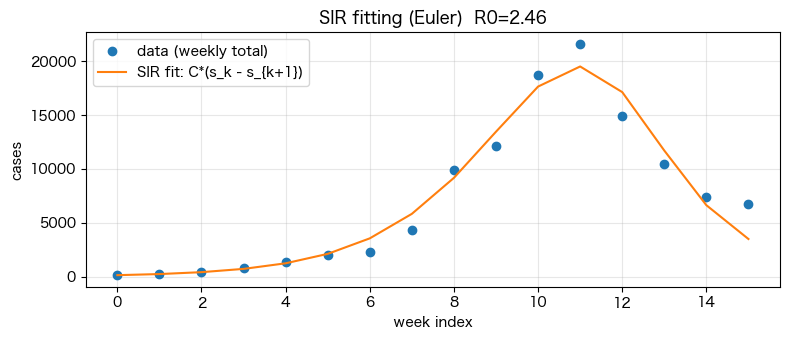

In [13]:
# 推定結果で予測
y_fit, s_fit, i_fit, r_fit = predict_weekly_cases(res.x)

weeks = np.arange(len(y), dtype=float)

plt.figure(figsize=(8,3.5))
plt.plot(weeks, y, "o", label="data (weekly total)")
plt.plot(weeks, y_fit, "-", label="SIR fit: C*(s_k - s_{k+1})")
plt.xlabel("week index")
plt.ylabel("cases")
plt.title(f"SIR fitting (Euler)  R0={beta_hat/gamma_hat:.2f}")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# # 残差
# plt.figure(figsize=(8,2.8))
# plt.plot(weeks, y - y_fit, "o-")
# plt.axhline(0, color="gray", lw=1)
# plt.xlabel("week index")
# plt.ylabel("residual (data - model)")
# plt.title("Residual")
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()
